# LIBARRIES DEPENDENCY

In [276]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold

from keras import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# GPU AVAILABILITY

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


# LOAD DATA

In [17]:
TEST_OUT_DIR  = r"C:\Users\Dixie\Documents\NTUST\Special Topic II\MI LR HAND\20262201_MIVerification\ProcessedDataset\TEST"
TRAIN_OUT_DIR = r"C:\Users\Dixie\Documents\NTUST\Special Topic II\MI LR HAND\20262201_MIVerification\ProcessedDataset\TRAIN"

In [ ]:
train_miDataset    = pd.read_csv(os.path.join(TRAIN_OUT_DIR, "mi_train_dataset_dixie.txt"), sep=" ", header=None)
train_restDataset  = pd.read_csv(os.path.join(TRAIN_OUT_DIR, "rest_train_dataset_dixie.txt"), sep=" ", header=None)
train_rawLabel     = pd.read_csv(os.path.join(TRAIN_OUT_DIR, "label_train_dataset_dixie.txt"), sep=" ", header=None)

test_miDataset    = pd.read_csv(os.path.join(TEST_OUT_DIR, "mi_test_dataset_dixie.txt"), sep=" ", header=None)
test_restDataset  = pd.read_csv(os.path.join(TEST_OUT_DIR, "rest_test_dataset_dixie.txt"), sep=" ", header=None)
test_rawLabel     = pd.read_csv(os.path.join(TEST_OUT_DIR, "label_test_dataset_dixie.txt"), sep=" ", header=None)

# Feature Extraction

**Discrete Fourier Transform:**

$$\bar{P}(T) = \frac{1}{T}\int_{0}^{T} |x(t)|^{2}\, dt$$

Where:
1. $x(t)$: EEG signal (voltage over time)  
2. $|x(t)|^2$: Instantaneous power (squared amplitude)  
3. $\bar{P}(T)$: Average power over the interval $[0, T]$

**Substitute X with Fourier Series:**

$$x(t)=\sum_{k=-\infty}^{\infty} c_k\,e^{j k\omega_0 t},
\quad \omega_0=\frac{2\pi}{T}$$

**Leads into:**

$$\bar{P}(T)=\frac{1}{T}\int_{0}^{T}
\left|\sum_{k=-\infty}^{\infty} c_k\,e^{j k\omega_0 t}\right|^2 dt$$

**Power Spectral Density (PSD):**
$$\bar{P}(T)=\frac{1}{T}\,|X_T(f)|^2$$

In [399]:
train_miDataset.shape
CHANNELS  = ["FC3", "FCz", "FC4", "C3", "Cz", "C4", "CP3", "CP4"]
BANDS     = {"Delta"    : (1, 4),
             "Theta"    : (4, 8),
             "Alpha"    : (8, 13),
             "Beta_Low" : (13, 20),
             "Beta_High": (20, 30),
             "Gamma"    : (30, 45)}

In [400]:
def bandPowerExtraction(x, fs = 500, n_ch = 8, bands = BANDS):
    temp_data      = np.asarray(x)
    n_trials, n_feat = temp_data.shape
    print(n_trials, n_feat)
    n_samples      = n_feat // n_ch
    if n_feat % n_ch != 0:
        return print("Row count not divisible by n_ch")
    #=======================================================================================
    # Reshape the data into 2D array: Trials x Channels x Samples
    #=======================================================================================
    data = temp_data.reshape((n_trials, n_ch, n_samples))
    #=======================================================================================
    # FFT and PSD Calculation
    #======================================================================================
    Xtf = np.fft.rfft(data, axis = -1)
    psd = (np.abs(Xtf)**2)/ n_samples
    freqs = np.fft.rfftfreq(n_samples, d=1/fs)

    feats = []
    feats_labels = []
    for ch in range(n_ch):
        for band, (f_low, f_high) in bands.items():
            thresh = (freqs >= f_low) & (freqs <= f_high)
            bp = psd[:, ch, :][:, thresh].sum(axis=1)

            feats.append(bp)
            feats_labels.append(f"{CHANNELS[ch]}_{band}")
    F = np.stack(feats, axis=1)
    return (F, feats_labels)

In [401]:
train_miDataset_temp = train_miDataset.to_numpy(dtype=float)
train_labelTemp      = train_rawLabel.iloc[:, 0].astype(str).values
train_label          = (train_labelTemp == "right").astype(int)

F_train, feat_names  = bandPowerExtraction(train_miDataset_temp)
df_features          = pd.DataFrame(F_train, columns=feat_names)

display(df_features.head(5))

80 16000


,FC3_Delta,FC3_Theta,FC3_Alpha,FC3_Beta_Low,FC3_Beta_High,FC3_Gamma,FCz_Delta,FCz_Theta,FCz_Alpha,FCz_Beta_Low,...,CP3_Alpha,CP3_Beta_Low,CP3_Beta_High,CP3_Gamma,CP4_Delta,CP4_Theta,CP4_Alpha,CP4_Beta_Low,CP4_Beta_High,CP4_Gamma
0,0.006156,0.005616,0.004534,0.005571,0.007321,0.006903,0.009736,0.008767,0.002898,0.005804,...,0.004119,0.005857,0.008798,0.005915,0.003864,0.004821,0.002695,0.005566,0.005989,0.005079
1,0.027278,0.009191,0.004532,0.006586,0.005408,0.004571,0.027507,0.013360,0.005767,0.006663,...,0.004994,0.006733,0.006164,0.003315,0.007409,0.006409,0.005470,0.004582,0.005043,0.003273
2,0.032267,0.012656,0.004883,0.004009,0.007921,0.004407,0.032576,0.015669,0.005475,0.004414,...,0.004462,0.006630,0.009288,0.003996,0.010501,0.007910,0.003778,0.004809,0.007252,0.003826
3,0.034937,0.012595,0.006113,0.006209,0.008212,0.005419,0.044361,0.022239,0.007491,0.006275,...,0.004529,0.005920,0.009559,0.004758,0.010664,0.009328,0.004574,0.004406,0.007114,0.004391
4,0.043493,0.012956,0.007452,0.003883,0.006677,0.005157,0.040731,0.014542,0.010149,0.004999,...,0.007108,0.008212,0.008206,0.003946,0.012158,0.006599,0.004278,0.004255,0.006603,0.003686


# Fischer Criterion

To judge and rank the bandpower features for Left vs Right MI

$$F(k)=\frac{S_B^{(k)}}{S_W^{(k)}}$$

$$S_B = \sum_{c=1}^{C} N_c (\mu_c - \mu)(\mu_c - \mu)^{T}$$

$$S_W = \sum_{c=1}^{C} \sum_{x \in c} (x - \mu_c)(x - \mu_c)^{T}$$

Where:

- $S_B^{(k)}$: **Between-class scatter** of feature $k$ 
- $S_W^{(k)}$: **Within-class scatter** of feature $k$

Set **k** feature to be one: evaluating the features **one by one**, thus the equation became: 

$$F=\frac{\left(\mu_1-\mu_2\right)^2}{\sigma_1^{2}+\sigma_2^{2}}$$

Link: https://en.wikipedia.org/wiki/Linear_discriminant_analysis

In [402]:
def fischerScore(X, y):
    X = np.asarray(X)
    y = np.asarray(y)
    X_Left  = X[y == 0]
    X_Right = X[y == 1]
    
    mu_Left   = X_Left.mean(axis=0)
    mu_Right  = X_Right.mean(axis=0)
    var_Left  = X_Left.var(axis=0)
    var_Right = X_Right.var(axis=0)

    F         = (mu_Left - mu_Right)**2 / (var_Left + var_Right)
    return F

## WITHOUT SUBSTRACTION TO BASELINE

,Feature,Fisher_score
35,C4_Gamma,0.038174
47,CP4_Gamma,0.031758
5,FC3_Gamma,0.027992
16,FC4_Beta_High,0.027105
29,Cz_Gamma,0.026249
11,FCz_Gamma,0.025242
17,FC4_Gamma,0.024285
41,CP3_Gamma,0.022682
38,CP3_Alpha,0.021469
34,C4_Beta_High,0.021178


Top 5 features: ['C4_Gamma', 'CP4_Gamma', 'FC3_Gamma', 'FC4_Beta_High', 'Cz_Gamma']


C4_Gamma           CP4_Gamma           FC3_Gamma            \
           mean       std      mean       std      mean       std   
label                                                               
left   0.002456  0.002434  0.002457  0.002400  0.003745  0.002872   
right  0.001962  0.000787  0.002011  0.000809  0.003237  0.001091   

      FC4_Beta_High            Cz_Gamma            
               mean       std      mean       std  
label                                              
left       0.004834  0.003169  0.002611  0.002634  
right      0.004295  0.000962  0.002171  0.000792

C:\Users\Dixie\AppData\Local\Temp\ipykernel_34304\2269272561.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([left_vals, right_vals], labels=["left", "right"])


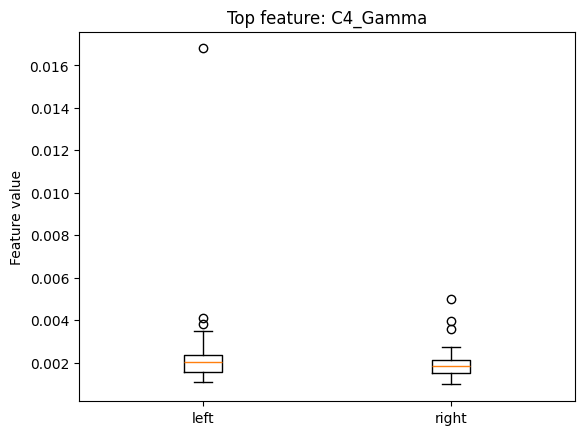

C:\Users\Dixie\AppData\Local\Temp\ipykernel_34304\2269272561.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([left_vals, right_vals], labels=["left", "right"])


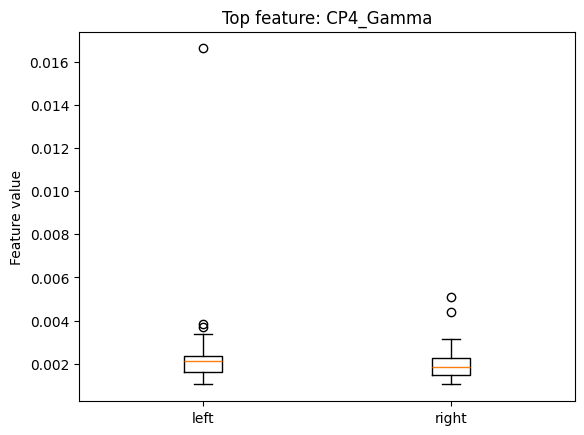

C:\Users\Dixie\AppData\Local\Temp\ipykernel_34304\2269272561.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([left_vals, right_vals], labels=["left", "right"])


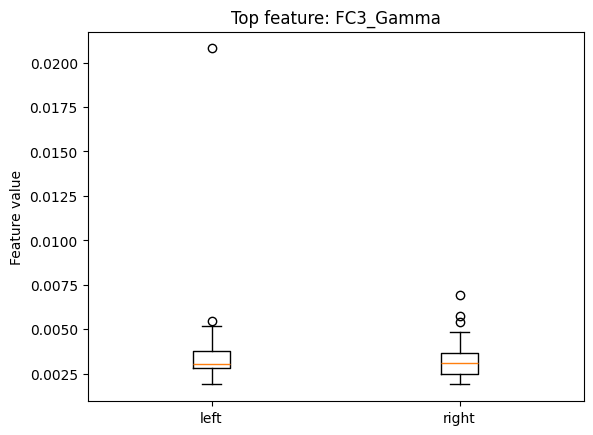

C:\Users\Dixie\AppData\Local\Temp\ipykernel_34304\2269272561.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([left_vals, right_vals], labels=["left", "right"])


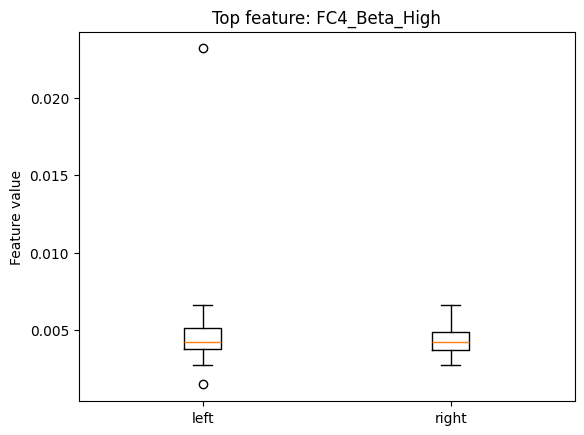

C:\Users\Dixie\AppData\Local\Temp\ipykernel_34304\2269272561.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([left_vals, right_vals], labels=["left", "right"])


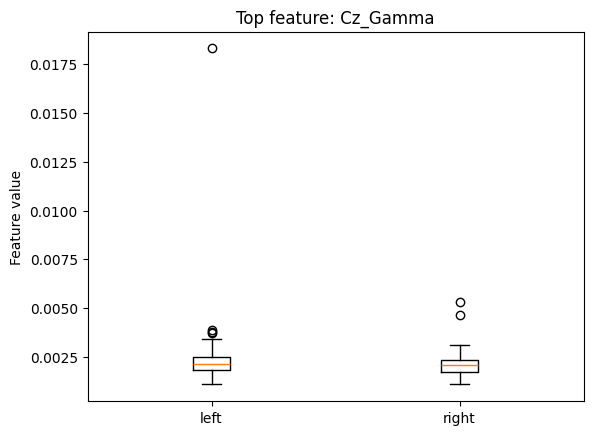

In [403]:
train_miFeat = df_features.to_numpy(dtype=float)
scores       = fischerScore(train_miFeat, train_label)

rank         = pd.DataFrame({"Feature": df_features.columns, "Fisher_score": scores}).sort_values("Fisher_score", ascending=False)
top5_FC      = rank["Feature"].head(5).tolist()
display(rank.head(10))
print("Top 5 features:", top5_FC)

df_top          = df_features[top5_FC].copy()
df_top["label"] = train_labelTemp

summary      = df_top.groupby("label")[top5_FC].agg(["mean", "std"])
display(summary)

for feat in top5_FC:
    plt.figure()
    left_vals  = df_features.loc[train_label == 0, feat].values
    right_vals = df_features.loc[train_label == 1, feat].values

    plt.boxplot([left_vals, right_vals], labels=["left", "right"])
    plt.title(f"Top feature: {feat}")
    plt.ylabel("Feature value")
    plt.show()

**Conclusion**: There's no clear distinct separation

## SUBSTRACTION TO BASELINE

**Purpose:** Substraction of MI - Rest  

$$\Delta = \log\!\left(BP_{\mathrm{MI}}\right) - \log\!\left(BP_{\mathrm{Rest}}\right)$$

80 16000
80 16000


,DELTA_FC3_Delta,DELTA_FC3_Theta,DELTA_FC3_Alpha,DELTA_FC3_Beta_Low,DELTA_FC3_Beta_High,DELTA_FC3_Gamma,DELTA_FCz_Delta,DELTA_FCz_Theta,DELTA_FCz_Alpha,DELTA_FCz_Beta_Low,...,DELTA_CP3_Alpha,DELTA_CP3_Beta_Low,DELTA_CP3_Beta_High,DELTA_CP3_Gamma,DELTA_CP4_Delta,DELTA_CP4_Theta,DELTA_CP4_Alpha,DELTA_CP4_Beta_Low,DELTA_CP4_Beta_High,DELTA_CP4_Gamma
0,-1.702387,-0.840984,0.336033,-0.151817,0.201356,-0.009553,-1.406495,-0.639435,-0.111995,-0.108617,...,0.592610,-0.236469,0.445925,0.160470,-1.304294,-0.432529,0.209220,0.008576,0.253112,0.213144
1,-0.567059,-0.585915,-0.158780,-0.014054,-0.271156,-0.098742,-0.642242,-0.372781,-0.103833,-0.178769,...,-0.357286,-0.299292,-0.353042,-0.252399,-0.774319,-0.135331,0.077523,-0.435324,-0.441790,-0.383362
2,0.126863,0.407450,0.603487,0.056543,-0.199812,-0.049325,-0.001458,0.371756,0.328652,0.183819,...,0.603855,0.130677,-0.153091,0.101438,-0.032378,0.553295,0.250513,-0.071289,-0.370246,-0.015655
3,1.050593,0.991808,0.938380,0.274132,0.184948,0.251145,1.076048,1.166162,0.791347,-0.099244,...,0.502896,-0.009995,0.086597,0.397498,0.629307,0.701027,0.545923,-0.517855,0.144147,0.276141
4,0.275269,-0.224796,0.177850,-0.254746,0.404816,0.447882,0.010313,-0.326253,0.390534,-0.363596,...,0.266829,0.546834,0.654197,0.239922,-0.182496,-0.030306,-0.155366,0.009399,0.390945,0.298955


,Feature,Fisher_score
12,DELTA_FC4_Delta,0.102093
30,DELTA_C4_Delta,0.098733
24,DELTA_Cz_Delta,0.094010
6,DELTA_FCz_Delta,0.084082
42,DELTA_CP4_Delta,0.083931
10,DELTA_FCz_Beta_High,0.069955
46,DELTA_CP4_Beta_High,0.062932
45,DELTA_CP4_Beta_Low,0.053398
18,DELTA_C3_Delta,0.051137
28,DELTA_Cz_Beta_High,0.049844


Top 5 features: ['DELTA_FC4_Delta', 'DELTA_C4_Delta', 'DELTA_Cz_Delta', 'DELTA_FCz_Delta', 'DELTA_CP4_Delta']


DELTA_FC4_Delta           DELTA_C4_Delta           DELTA_Cz_Delta  \
                 mean       std           mean       std           mean   
label                                                                     
left        -0.359847  0.796514      -0.373364  0.718696      -0.308660   
right       -0.013843  0.753840      -0.069011  0.667626      -0.051961   

                DELTA_FCz_Delta           DELTA_CP4_Delta            
            std            mean       std            mean       std  
label                                                                
left   0.635030       -0.309679  0.748174       -0.370758  0.656233  
right  0.561821       -0.022551  0.667734       -0.123751  0.561187

C:\Users\Dixie\AppData\Local\Temp\ipykernel_34304\2677383857.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([left_vals, right_vals], labels=["left", "right"])


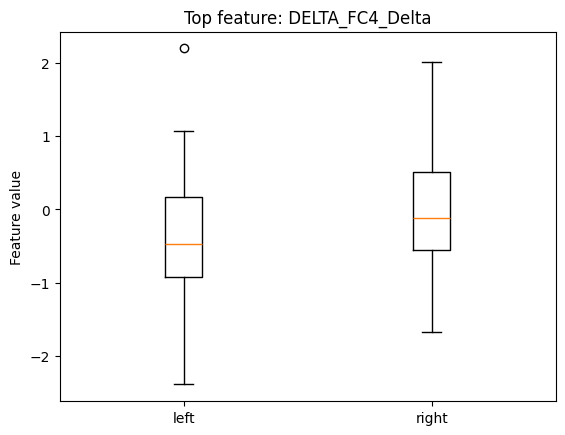

C:\Users\Dixie\AppData\Local\Temp\ipykernel_34304\2677383857.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([left_vals, right_vals], labels=["left", "right"])


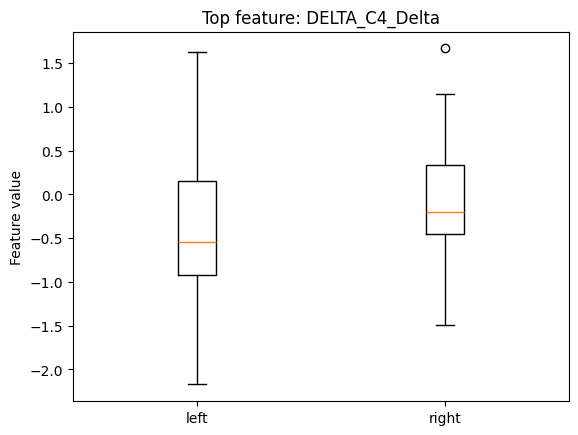

C:\Users\Dixie\AppData\Local\Temp\ipykernel_34304\2677383857.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([left_vals, right_vals], labels=["left", "right"])


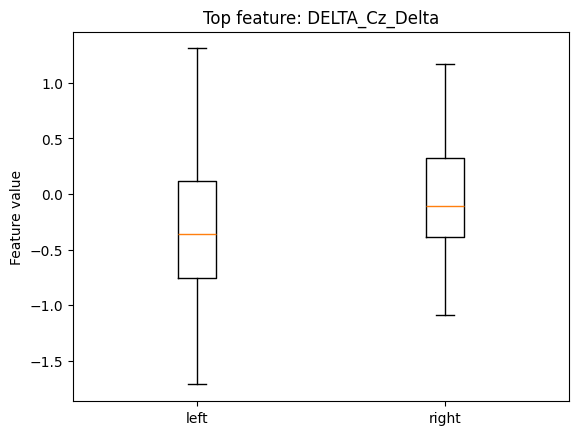

C:\Users\Dixie\AppData\Local\Temp\ipykernel_34304\2677383857.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([left_vals, right_vals], labels=["left", "right"])


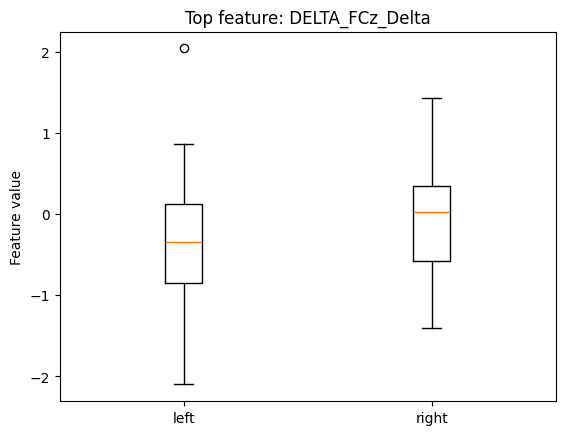

C:\Users\Dixie\AppData\Local\Temp\ipykernel_34304\2677383857.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([left_vals, right_vals], labels=["left", "right"])


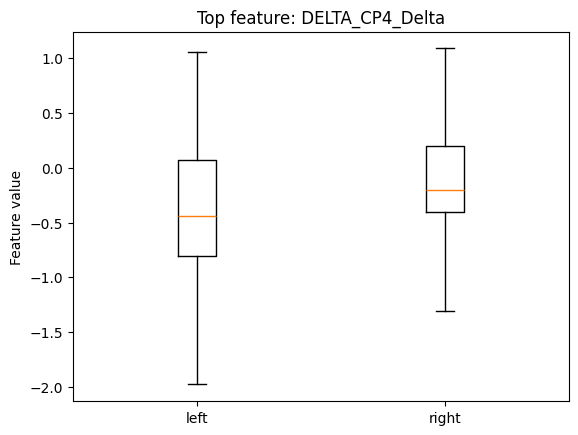

In [404]:
train_miDataset_temp1   = train_miDataset.to_numpy(dtype=float)
train_restDataset_temp1 = train_restDataset.to_numpy(dtype=float)

F_miTrain, feat_names   = bandPowerExtraction(train_miDataset_temp1)
F_restTrain, feat_names = bandPowerExtraction(train_restDataset_temp1)

F_deltaTrain  = np.log(F_miTrain) - np.log(F_restTrain)
df_deltaTrain = pd.DataFrame(F_deltaTrain, columns=[f"DELTA_{n}" for n in feat_names])
display(df_deltaTrain.head(5))

scores   = fischerScore(df_deltaTrain, train_label)

rank     = pd.DataFrame({"Feature": df_deltaTrain.columns, "Fisher_score": scores}).sort_values("Fisher_score", ascending=False)
top5_FC  = rank["Feature"].head(5).tolist()
display(rank.head(10))
print("Top 5 features:", top5_FC)

df_top  = df_deltaTrain[top5_FC].copy()
df_top["label"] = train_labelTemp

summary = df_top.groupby("label")[top5_FC].agg(["mean", "std"])
display(summary)

for feat in top5_FC:
    plt.figure()
    left_vals  = df_deltaTrain.loc[train_label == 0, feat].values
    right_vals = df_deltaTrain.loc[train_label == 1, feat].values
    plt.boxplot([left_vals, right_vals], labels=["left", "right"])
    plt.title(f"Top feature: {feat}")
    plt.ylabel("Feature value")
    plt.show()


In [405]:
#======================================================================================================
# COMPUTING DF DELTA TEST DATASET SUBSTRACTING MI FROM REST
#======================================================================================================
test_miDataset_temp    = test_miDataset.to_numpy(dtype=float)
test_restDataset_temp  = test_restDataset.to_numpy(dtype=float)

F_miTest, feat_names   = bandPowerExtraction(test_miDataset_temp)
F_restTest, feat_names = bandPowerExtraction(test_restDataset_temp)

F_deltaTest  = np.log(F_miTest) - np.log(F_restTest)
df_deltaTest = pd.DataFrame(F_deltaTest, columns=[f"DELTA_{n}" for n in feat_names])
display(df_deltaTest.head(5))

20 16000
20 16000


,DELTA_FC3_Delta,DELTA_FC3_Theta,DELTA_FC3_Alpha,DELTA_FC3_Beta_Low,DELTA_FC3_Beta_High,DELTA_FC3_Gamma,DELTA_FCz_Delta,DELTA_FCz_Theta,DELTA_FCz_Alpha,DELTA_FCz_Beta_Low,...,DELTA_CP3_Alpha,DELTA_CP3_Beta_Low,DELTA_CP3_Beta_High,DELTA_CP3_Gamma,DELTA_CP4_Delta,DELTA_CP4_Theta,DELTA_CP4_Alpha,DELTA_CP4_Beta_Low,DELTA_CP4_Beta_High,DELTA_CP4_Gamma
0,-1.534931,-0.143243,-0.414630,0.056053,-0.148564,0.094237,-1.088130,-0.070746,-0.336561,-0.322485,...,-0.722450,-0.269626,-0.020650,0.027491,-1.239870,-0.422000,-0.435198,-0.724445,0.185742,0.424618
1,-0.224984,-0.753727,0.740784,0.133596,0.086032,-0.250739,-0.266121,-0.621756,0.070713,0.471127,...,0.488427,0.318159,0.104025,-0.335796,-0.067561,-0.557863,0.431991,0.673017,0.051122,-0.423045
2,0.486956,0.415306,-0.340157,-0.543846,0.488757,0.033934,0.369643,0.286093,-0.010366,-0.522786,...,-0.194303,-0.567264,0.089615,0.035253,0.283305,0.214721,0.513372,-0.668443,0.295185,0.177179
3,-1.263667,-0.764345,-0.523769,0.340587,0.292667,0.169328,-1.558790,-0.652096,-0.648216,0.295556,...,-0.007979,0.668930,0.346548,0.103632,-1.586259,-0.726437,0.007197,0.241477,0.065904,0.037082
4,0.258798,0.363745,0.573595,-0.033957,0.333963,0.184135,0.259074,0.387113,0.578313,0.231740,...,0.053052,-0.167706,-0.069376,0.248672,0.191575,0.205144,0.135157,0.551149,0.036527,0.341708


# Re-Configure the Dataset

In [406]:
topFeatures = rank["Feature"].head(5).tolist()
print("Top 5 features:", topFeatures)

X_train = df_deltaTrain[topFeatures].to_numpy(dtype=float)
X_test  = df_deltaTest[topFeatures].to_numpy(dtype=float)

y_train = train_rawLabel.iloc[:,0].astype(str).str.strip().map({"left":0, "right":1}).to_numpy()
y_test  = test_rawLabel.iloc[:,0].astype(str).str.strip().map({"left":0, "right":1}).to_numpy()

print("Train Dataset :", X_train.shape, y_train.shape)
print("Test Dataset  :",  X_test.shape,  y_test.shape)

Top 5 features: ['DELTA_FC4_Delta', 'DELTA_C4_Delta', 'DELTA_Cz_Delta', 'DELTA_FCz_Delta', 'DELTA_CP4_Delta']
Train Dataset : (80, 5) (80,)
Test Dataset  : (20, 5) (20,)


# Algorithm

In [407]:
LDA = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis())
])
LDA.fit(X_train, y_train)
y_pred = LDA.predict(X_test)

print("LDA accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["left","right"]))

LDA accuracy: 0.65
Confusion matrix:
 [[7 3]
 [4 6]]
              precision    recall  f1-score   support

        left       0.64      0.70      0.67        10
       right       0.67      0.60      0.63        10

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



In [408]:
LDAResults = []

for K in range(1, df_deltaTrain.shape[1] + 1):
    topK = rank["Feature"].head(K).tolist()
    Xtr = df_deltaTrain[topK].to_numpy(dtype=float)
    Xte = df_deltaTest[topK].to_numpy(dtype=float)

    LDA.fit(Xtr, y_train)
    acc = accuracy_score(y_test, LDA.predict(Xte))
    LDAResults.append((K, acc))

df_res = pd.DataFrame(LDAResults, columns=["Number of Features", "LDA_acc"])
best_row = df_res.iloc[df_res["LDA_acc"].idxmax()]
print(f"Best LDA: Top Number of Features={int(best_row['Number of Features'])} acc={best_row['LDA_acc']:.3f}")

Best LDA: Top Number of Features=18 acc=0.750


In [409]:
bestKNN = (-1, None, None)
for k in [1, 3, 5, 7, 9, 11, 13, 15]:
    KNN = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    KNN.fit(X_train, y_train)
    y_pred = KNN.predict(X_test)
    acc    = accuracy_score(y_test, y_pred)

    print(f"KNN - k={k} acc={acc:.3f}")
    
    if acc > bestKNN[0]: bestKNN = (acc, k, y_pred)

print("Best KNN: k=", bestKNN[1], "acc:", bestKNN[0])
print("Confusion matrix:\n", confusion_matrix(y_test, bestKNN[2]))
print(classification_report(y_test, bestKNN[2], target_names=["left","right"]))


KNN - k=1 acc=0.450
KNN - k=3 acc=0.350
KNN - k=5 acc=0.450
KNN - k=7 acc=0.350
KNN - k=9 acc=0.450
KNN - k=11 acc=0.500
KNN - k=13 acc=0.550
KNN - k=15 acc=0.500
Best KNN: k= 13 acc: 0.55
Confusion matrix:
 [[5 5]
 [4 6]]
              precision    recall  f1-score   support

        left       0.56      0.50      0.53        10
       right       0.55      0.60      0.57        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



In [410]:
neighbor_list = [1, 3, 5, 7, 9, 11, 13, 15]
KNNBestResults = (-1, None, None, None)
rows = []

for K in range(1, df_deltaTrain.shape[1] + 1):
    topK = rank["Feature"].head(K).tolist()
    Xtr = df_deltaTrain[topK].to_numpy(dtype=float)
    Xte = df_deltaTest[topK].to_numpy(dtype=float)
    for k_neighbors in neighbor_list:
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(n_neighbors=k_neighbors))
        ])

        model.fit(Xtr, y_train)
        y_pred = model.predict(Xte)
        acc = accuracy_score(y_test, y_pred)
        rows.append((K, k_neighbors, acc))
        if acc > KNNBestResults[0]: KNNBestResults = (acc, K, k_neighbors, y_pred)
df_knn_grid = pd.DataFrame(rows, columns=["TopK_features", "k_neighbors", "acc"])
display(df_knn_grid.sort_values("acc", ascending=False).head(20))

print(f"Best KNN: TopK_features={KNNBestResults[1]}, k_neighbors={KNNBestResults[2]}, acc={KNNBestResults[0]:.3f}")
print("Confusion matrix:\n", confusion_matrix(y_test, KNNBestResults[3]))
print(classification_report(y_test, KNNBestResults[3], target_names=["left","right"]))


,TopK_features,k_neighbors,acc
70,9,13,0.75
69,9,11,0.75
76,10,9,0.75
78,10,13,0.75
148,19,9,0.70
103,13,15,0.70
108,14,9,0.70
111,14,15,0.70
295,37,15,0.70
327,41,15,0.70


Best KNN: TopK_features=9, k_neighbors=11, acc=0.750
Confusion matrix:
 [[7 3]
 [2 8]]
              precision    recall  f1-score   support

        left       0.78      0.70      0.74        10
       right       0.73      0.80      0.76        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20



In [ ]:
scaler        = StandardScaler()
X_trainScaled = scaler.fit_transform(X_train)
X_testScaled  = scaler.transform(X_test)

def ANN_Model(n_features, lr=1e-3):
    model = Sequential([
        Input(shape=(n_features,)),
        Dense(12, activation= 'relu', kernel_regularizer= tf.keras.regularizers.l2(1e-3)),
        Dropout(0.1),
        Dense(8, activation= 'relu', kernel_regularizer= tf.keras.regularizers.l2(1e-3)),
        Dropout(0.1),
        Dense(1, activation= 'sigmoid')
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    model.compile(opt, loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
    return model

callbacks = [EarlyStopping(monitor="val_loss", patience= 30, restore_best_weights=True)]

In [484]:
X_tr, X_val, y_tr, y_val = train_test_split(X_trainScaled, y_train, test_size=0.2, random_state=42, stratify=y_train) 

model = ANN_Model(X_tr.shape[1])

history = model.fit(
    X_tr, y_tr,
    validation_data =(X_val, y_val),
    epochs          =200,
    batch_size      =8,
    callbacks       =callbacks,
    verbose         =1
)

test_loss, test_acc, test_auc = model.evaluate(X_testScaled, y_test, verbose=0)
print(f"Test acc={test_acc:.3f}, AUC={test_auc:.3f}")

prob = model.predict(X_testScaled).ravel()
pred = (prob >= 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, pred))
print("AUC:", roc_auc_score(y_test, prob))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, target_names=["left","right"]))

Epoch 1/200
8/8 [==============================] - 1s 32ms/step - loss: 0.7736 - accuracy: 0.4844 - auc: 0.4185 - val_loss: 0.7687 - val_accuracy: 0.5000 - val_auc: 0.3125
Epoch 2/200
8/8 [==============================] - 0s 11ms/step - loss: 0.7759 - accuracy: 0.4219 - auc: 0.3145 - val_loss: 0.7558 - val_accuracy: 0.5000 - val_auc: 0.3594
Epoch 3/200
8/8 [==============================] - 0s 11ms/step - loss: 0.7696 - accuracy: 0.3594 - auc: 0.3076 - val_loss: 0.7466 - val_accuracy: 0.5000 - val_auc: 0.4297
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.7518 - accuracy: 0.4688 - auc: 0.3335 - val_loss: 0.7408 - val_accuracy: 0.5000 - val_auc: 0.3750
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.7374 - accuracy: 0.4844 - auc: 0.4194 - val_loss: 0.7345 - val_accuracy: 0.5625 - val_auc: 0.4062
Epoch 6/200
8/8 [==============================] - 0s 12ms/step - loss: 0.7189 - accuracy: 0.5156 - auc: 0.4482 - val_loss: 0.7290 - val_acc

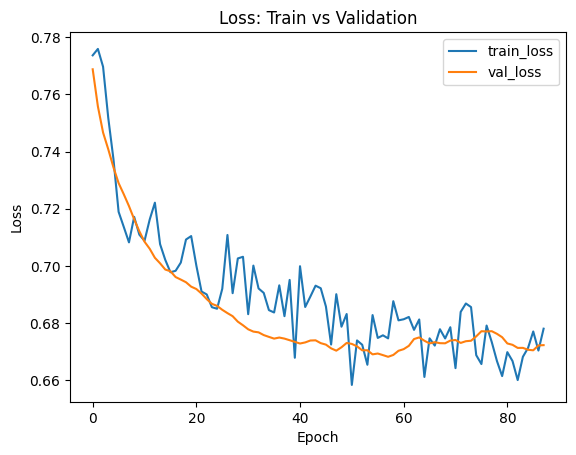

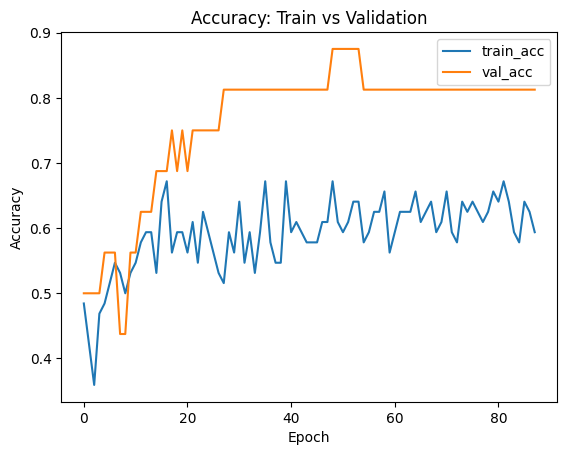

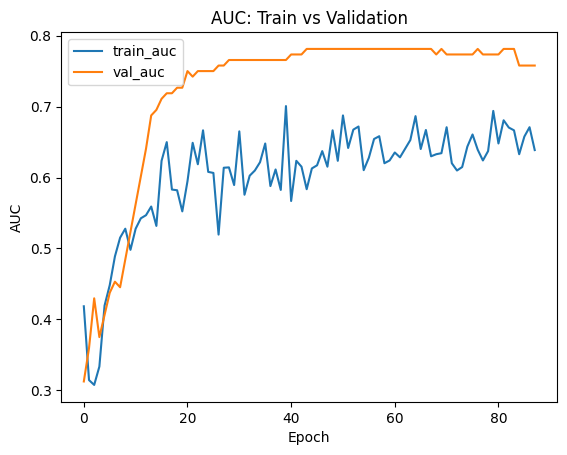

In [485]:
hist = history.history  # dictionary

plt.figure()
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss: Train vs Validation")
plt.legend()
plt.show()

if "accuracy" in hist and "val_accuracy" in hist:
    plt.figure()
    plt.plot(hist["accuracy"], label="train_acc")
    plt.plot(hist["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy: Train vs Validation")
    plt.legend()
    plt.show()

if "auc" in hist and "val_auc" in hist:
    plt.figure()
    plt.plot(hist["auc"], label="train_auc")
    plt.plot(hist["val_auc"], label="val_auc")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.title("AUC: Train vs Validation")
    plt.legend()
    plt.show()